https://www.youtube.com/watch?v=Wqmtf9SA_kk

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = "../nybolig-scrape/"
data = pd.read_csv(path+"nybolig_data.csv")
postal_codes = (1000, 2900)
data = data[(data['postal_code'] >= postal_codes[0]) & (data['postal_code'] <= postal_codes[1])]

#Count the number of types 
data = data[(data['type'] == 'ejerlejlighed')]

display(data['type'].value_counts())
display(data.head())
display(data.info())

type
ejerlejlighed    282
Name: count, dtype: int64

,url,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label
0,https://www.nybolig.dk/ejerlejlighed/2300/amag...,Amagerfælledvej 138 2. tv 2300 København S,2300,ejerlejlighed,3995000,89,NaN,3,2018,NaN,A2015
1,https://www.nybolig.dk/ejerlejlighed/2800/ulri...,Ulrikkenborg Alle 22 1. tv 2800 Kongens Lyngby,2800,ejerlejlighed,2325000,54,NaN,2,1934,NaN,D
2,https://www.nybolig.dk/ejerlejlighed/2630/save...,Saven B 4 3. 3 Høje Taastrup 2630 Taastrup,2630,ejerlejlighed,2195000,99,NaN,4,1974,NaN,C
3,https://www.nybolig.dk/ejerlejlighed/2000/fins...,Finsensvej 11C 6. tv 2000 Frederiksberg,2000,ejerlejlighed,7995000,126,NaN,5,1969,NaN,D
4,https://www.nybolig.dk/ejerlejlighed/1799/fade...,Fadet 6 33. 4 1799 København V,1799,ejerlejlighed,10200000,118,NaN,4,2022,NaN,A2015


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            282 non-null    object 
 1   address        282 non-null    object 
 2   postal_code    282 non-null    int64  
 3   type           282 non-null    object 
 4   price          282 non-null    int64  
 5   size           282 non-null    int64  
 6   basement_size  0 non-null      float64
 7   rooms          282 non-null    int64  
 8   year_built     282 non-null    int64  
 9   year_rebuilt   34 non-null     float64
 10  energy_label   275 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 24.4+ KB


None

# Data Exploration

In [ ]:
from sklearn.model_selection import train_test_split
X = data.drop(['price'], axis = 1)
y = data['price']

In [ ]:
data = data[(data['postal_code'] >= 1000) & (data['postal_code'] <= 2920)]

# set the data to only "ejerlejlighed" on its type
data = data[data['type'] == 'ejerlejlighed']

len(data)

In [ ]:
data.hist(figsize = (15, 8))

In [ ]:
plt.figure(figsize = (15, 8))
sns.heatmap(data.select_dtypes(include = np.number).corr(), annot = True, cmap = "YlGnBu")

# Preprocessing

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [4]:
from geopy.geocoders import Nominatim
import re

loc = Nominatim(user_agent = "GetLoc")
def get_lat_long(addresses): 
    #Get the latitude and longitude of the address
    long, lat = [], []
    for address in addresses:
        match = re.search(r"(.*?)\d", address)
        address = match.group(1)
        locations = loc.geocode(address, exactly_one = False)
        #Select location from location that is clostest to (55, 12)
        location = min(locations, key = lambda loc: (loc.latitude - 55)**2 + (loc.longitude - 12)**2)

        #Verify that the location is within (54,12) and (56, 13)
        if location.latitude < 54 or location.latitude > 56 or location.longitude < 12 or location.longitude > 13:
            long.append(None)
            lat.append(None)
        else:
            long.append(location.longitude)
            lat.append(location.latitude)
    return lat, long

def transformation(data):
    data['postal_code'] = (data['postal_code'] + 1) ** 2
    data['rooms'] = np.log(data['rooms'] + 1)
    data['size'] = np.log(data['size'] + 1)
    data['basement_size'] = np.log(data['basement_size'] + 1)
    data['year_built'] = (data['year_built'] + 1) ** 2
    data['year_rebuilt'] = (data['year_rebuilt'] + 1) ** 2
    return data

def encode(data, encoding = 'normal'):
    if encoding == 'normal':
        data['type'] = data['type'].astype('category').cat.codes
        data['energy_label'] = data['energy_label'].astype('category').cat.codes
        data['postal_code'] = data['postal_code'].astype('category').cat.codes
    elif encoding == 'onehot':
        data = pd.get_dummies(data, columns = ['type', 'energy_label', "postal_code"], drop_first = True, dtype=int)
    else:
        raise ValueError("The encoding parameter must be either 'normal' or 'onehot'")
    return data

def drop_low_corr_(data):
    for column in data.select_dtypes(include = np.number).columns:
        if abs(data[column].corr(data['price'])) < 0.1:
            data = data.drop(column, axis = 1)
    return data

def preprocess_data(data, 
                    transformations: bool = False, 
                    encoding: str = 'normal', 
                    drop_low_corr: bool = False,
                    long_lat: bool = False):
    # Fill the missing values
    data['year_rebuilt'] = data['year_rebuilt'].where(~data['year_rebuilt'].isna(), data['year_built']).astype(int)
    data['basement_size'] = data["basement_size"].fillna(0)

    #Set the longitude and latitude
    if long_lat:
        data['latitude'], data['longitude'] = get_lat_long(data['address'])
        

    # Apply the transformations
    if transformations:
        data = transformation(data)
        
    #Set label as above or below mean: 
    mean = data['price'].mean()
    data['above_mean'] = data['price'].apply(lambda x: 1 if x > mean else 0)
    
    # Apply the encoding
    data = encode(data, encoding)

    # Drop the columns that have low correlation with the target variable
    if drop_low_corr:
        drop_low_corr_(data)
        
    # Drop the columns that are not needed
    data = data.drop(['url', 'address'], axis = 1)

    return data

In [6]:
preprocessed_data = preprocess_data(data, transformations = False, encoding = 'normal', drop_low_corr = True, long_lat = False)

/usr/local/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

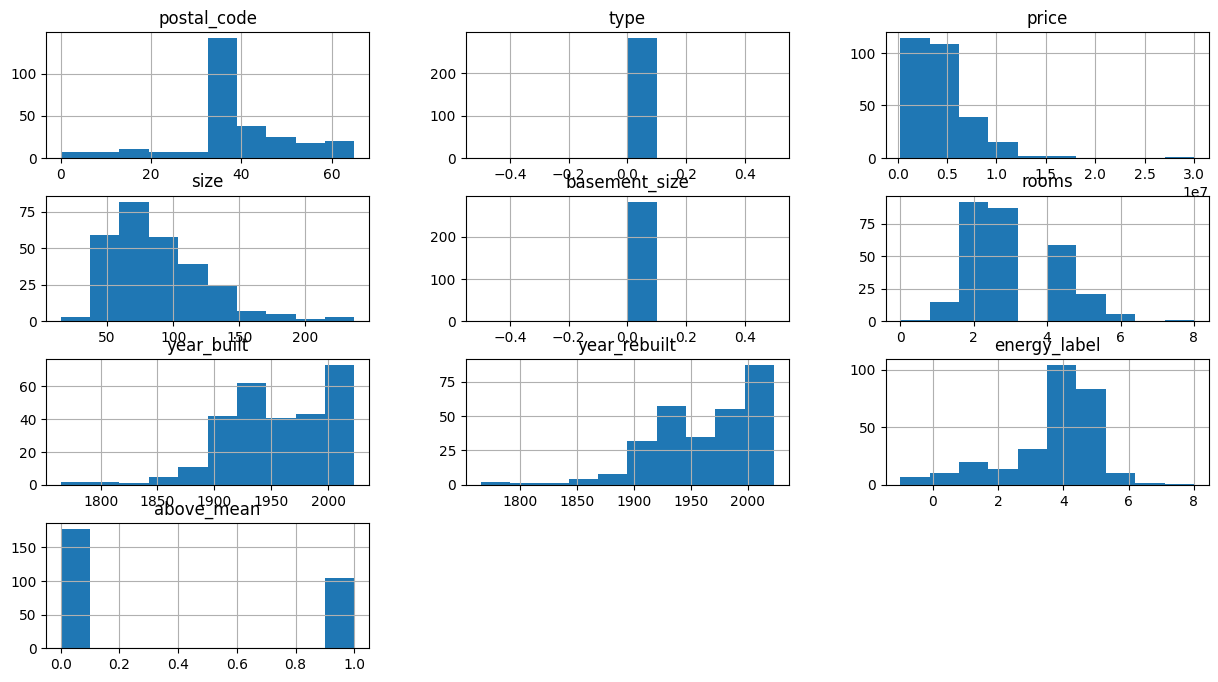

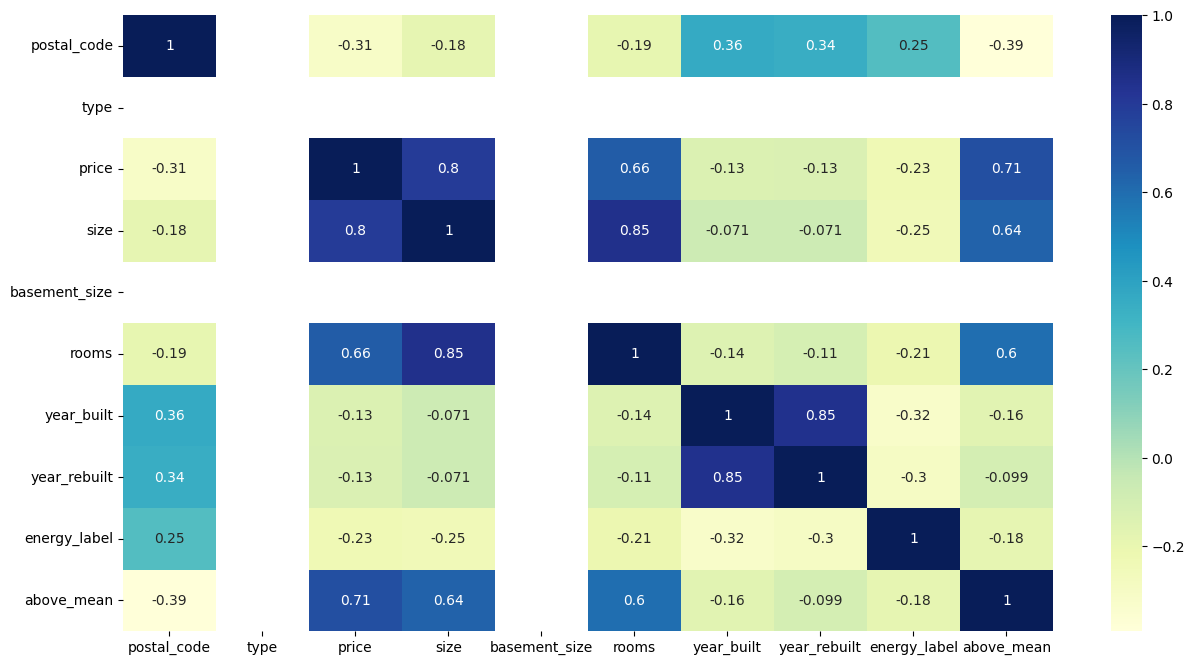

In [7]:
preprocessed_data.hist(figsize = (15, 8))
plt.figure(figsize = (15, 8))
sns.heatmap(preprocessed_data.select_dtypes(include = np.number).corr(), annot = True, cmap = "YlGnBu")

#  Price Regression 

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data.drop(['price', 'above_mean'], axis = 1), preprocessed_data['price'], test_size = 0.2, random_state = 0)
display(X_train)
display(y_train)

,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label
176,33,0,93,0.0,4,1926,1926,4
200,36,0,93,0.0,3,2023,2023,2
157,36,0,65,0.0,2,1926,1926,4
27,37,0,36,0.0,1,1936,1936,5
173,35,0,108,0.0,4,1933,1933,4
...,...,...,...,...,...,...,...,...
251,36,0,139,0.0,5,1935,2009,4
192,34,0,80,0.0,3,1896,1933,5
117,34,0,59,0.0,2,1934,1934,4
47,33,0,174,0.0,6,1901,1901,5


176    4995000
200    7995000
157    2695000
27     1795000
173    4250000
        ...   
251    5995000
192    5650000
117    3795000
47     7995000
172    4495000
Name: price, Length: 225, dtype: int64

## Linear, Lasso and Ridge Regression 

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
warnings.simplefilter(action='ignore', category=FutureWarning)
np.set_printoptions(suppress=True)

Scores [0.67887986 0.75299265 0.57655009 0.45551694 0.75668832]
Test score:  0.7129267203691773

Coefficients: 
postal_code: -42083.311570220816
type: 2.964952727779746e-10
size: 74871.39928933364
basement_size: 7.639755494892597e-11
rooms: -298389.64196025225
year_built: -749.5724103869179
year_rebuilt: 1840.6489164064114
energy_label: -36142.949781382005

Intercept:  -1465180.0478800088

Evaluation
Mean squared error:  2047511305956.8237
Mean absolute error:  1082924.756417669
R2 score:  0.7129267203691773


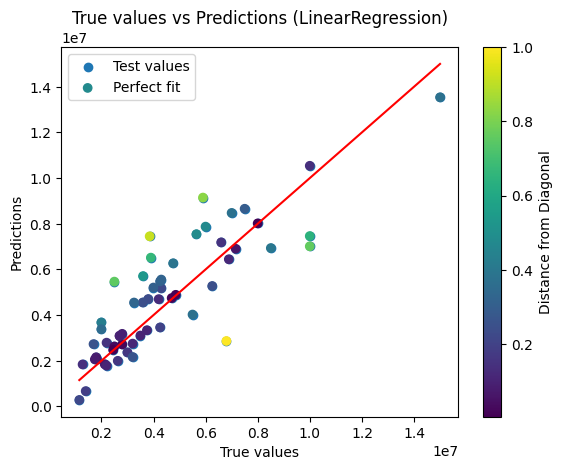

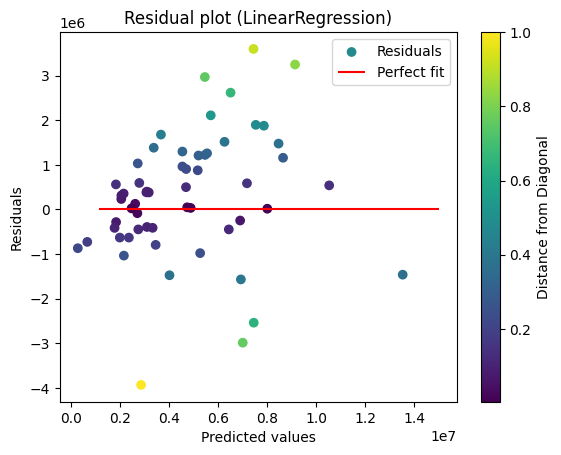

Scores [0.67657238 0.75356473 0.58460792 0.45545372 0.75621051]
Test score:  0.7137132112323337

Coefficients: 
postal_code: -42123.26796081376
type: 0.0
size: 73931.4595381915
basement_size: 0.0
rooms: -263713.60581844294
year_built: -615.5945114040542
year_rebuilt: 1765.1904345625885
energy_label: -35287.20474084662

Intercept:  -1602213.3534874618

Evaluation
Mean squared error:  2041901766342.3555
Mean absolute error:  1081197.3776962704
R2 score:  0.7137132112323337


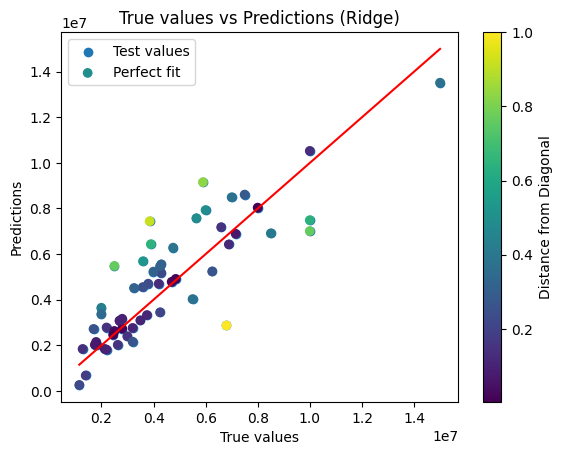

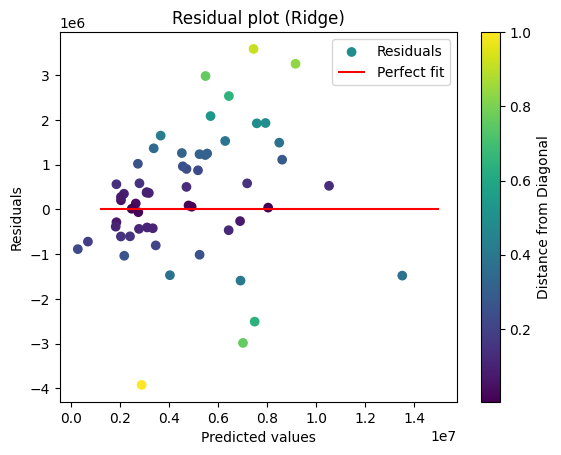

Scores [0.67887908 0.75299386 0.57655502 0.45551702 0.75668806]
Test score:  0.7129275462199288

Coefficients: 
postal_code: -42083.513521323526
type: 0.0
size: 74870.61858580953
basement_size: 0.0
rooms: -298359.29785467853
year_built: -749.3885301983838
year_rebuilt: 1840.6005326202458
energy_label: -36137.35192388486

Intercept:  -1465480.5298203602

Evaluation
Mean squared error:  2047505415688.1335
Mean absolute error:  1082922.1884944136
R2 score:  0.7129275462199288


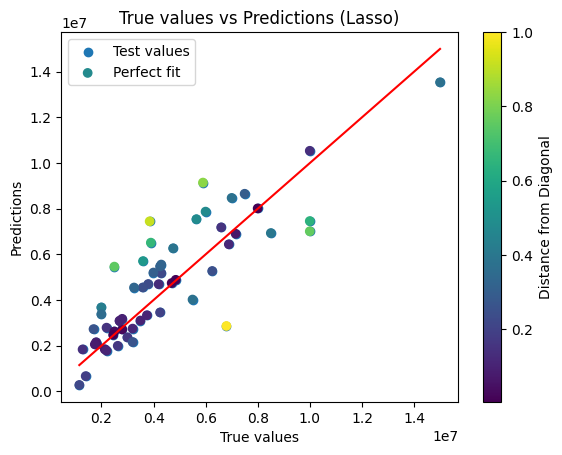

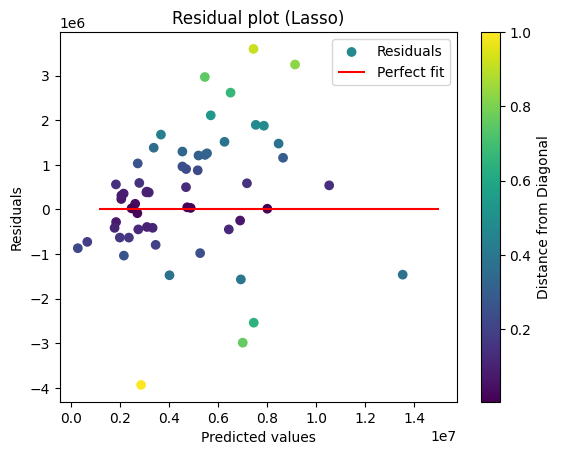

In [799]:
import numpy as np
import matplotlib.pyplot as plt

def regression(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    score = cross_val_score(model, x_train, y_train, cv=5)
    print("Scores", score)
    print("Test score: ", model.score(x_test, y_test))
    print("\nCoefficients: ")
    for feature, coef in zip(x_train.columns, model.coef_):
        print(f"{feature}: {coef}")
    print("\nIntercept: ", model.intercept_)

    # Predicting the test set results
    y_pred = model.predict(x_test)
    
    #Evaluating the model
    print("\nEvaluation")
    print("Mean squared error: ", mean_squared_error(y_test, y_pred))
    print("Mean absolute error: ", mean_absolute_error(y_test, y_pred))
    print("R2 score: ", r2_score(y_test, y_pred))

    # Plotting the results
    plot_regression_results(model.__class__.__name__, y_test, y_pred)

linear_model_ = linear_model.LinearRegression()
lasso_model = linear_model.Lasso(alpha = 10)
ridge_model = linear_model.Ridge(alpha = 10)
regression(linear_model_, X_train, y_train, X_test, y_test)
regression(ridge_model, X_train, y_train, X_test, y_test)
regression(lasso_model, X_train, y_train, X_test, y_test)

For this results, we have the following: 
  1. Scores: These are cross-validation scores obtained using 5-fold cross-validation. They represent the R-squared values achieved by the Lasso model on different folds of the training data. Each score corresponds to one fold.
  2. Test score: This is the R-squared score of the model on the held-out test set.
  3. Coefficients: These are the weights assigned to each feature by the  model. 
  4. Intercept: This is the bias term of the model.

## Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state = 0)
forest.fit(X_train, y_train)

Feauture Importance
postal_code 0.0868
type 0.0
size 0.6837
basement_size 0.0
rooms 0.0096
year_built 0.1098
year_rebuilt 0.0902
energy_label 0.0198
R2 score:  0.7567918600092913
Mean squared error:  1734649135482.4072
Mean absolute error:  834044.8245614035


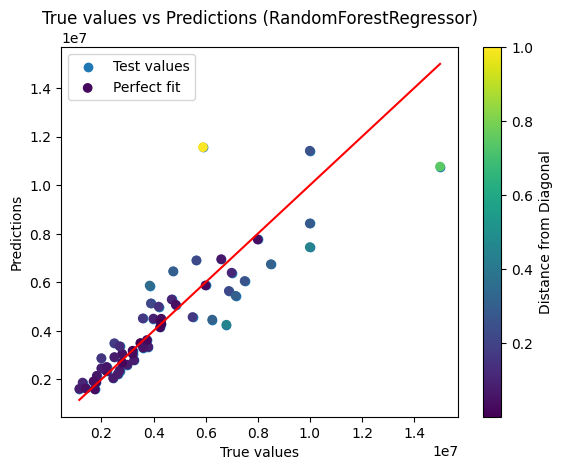

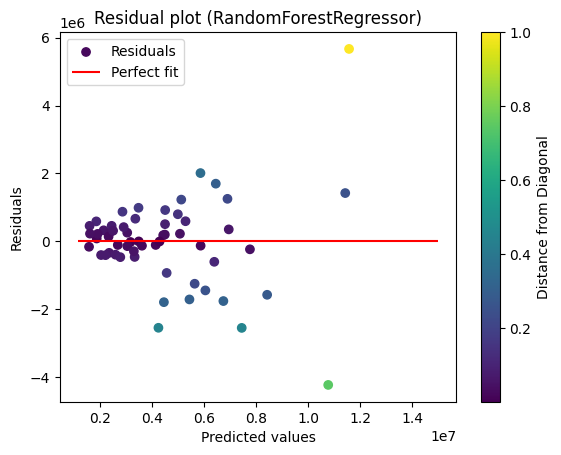

In [795]:
print("Feauture Importance")
for feature, importance in zip(X_train.columns, forest.feature_importances_):
    print((feature), round(importance,4))
print("R2 score: ", forest.score(X_test, y_test))
print("Mean squared error: ", mean_squared_error(y_test, forest.predict(X_test)))
print("Mean absolute error: ", mean_absolute_error(y_test, forest.predict(X_test)))

plot_regression_results(forest.__class__.__name__, y_test, forest.predict(X_test))

### Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [500, 1000, 1500],
#     'max_features': [3, 4, 5],
# }

# grid_search = GridSearchCV(forest, param_grid, cv = 5, scoring='neg_mean_squared_error', return_train_score=True)
# grid_search.fit(X_train, y_train)
# best_forest = grid_search.best_estimator_
# best_forest

In [ ]:
# best_forest.score(X_test, y_test)

In [ ]:
# print("Best parameters: ", grid_search.best_params_)
# print("R2 score: ", best_forest.score(X_test, y_test))
# print("Mean squared error: ", mean_squared_error(y_test, best_forest.predict(X_test)))
# print("Mean absolute error: ", mean_absolute_error(y_test, best_forest.predict(X_test)))

# plot_regression_results(best_forest.__class__.__name__, y_test, best_forest.predict(X_test))

## Extreme Gradient Boosting 

In [ ]:
import xgboost as xgb

R2 score:  0.6108366916294041
Mean squared error:  2775654616051.572
Mean absolute error:  919874.9649122807


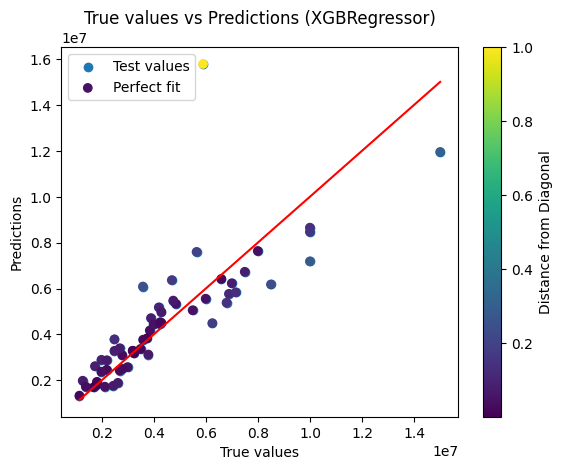

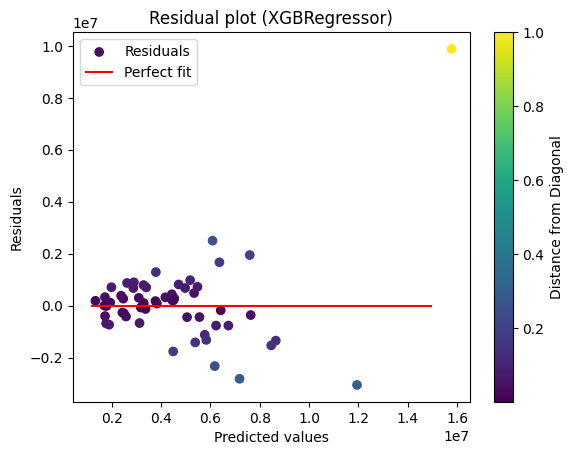

In [794]:
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 300, learning_rate = 0.1, max_depth = 3)
xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_test)
print("R2 score: ", r2_score(y_test, pred))
print("Mean squared error: ", mean_squared_error(y_test, pred))
print("Mean absolute error: ", mean_absolute_error(y_test, pred))

plot_regression_results(xgb_model.__class__.__name__, y_test, pred)


## Neural Network Apporach 

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber, LogCosh, MeanSquaredLogarithmicError, CosineSimilarity, KLDivergence, Poisson, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, Poisson, KLDivergence, SquaredHinge, Hinge


2024-02-22 09:29:16.555869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
from utils import regression_stats, plot_regression_results
def neural_network(x_train, y_train, x_test, y_test): 
  #turn y_train and y_test into log(y_train) and log(y_test)
  y_train = np.log(y_train)
  y_test = np.log(y_test)
  scale = False 
  if scale: 
    scale = StandardScaler()
    x_train = scale.fit_transform(x_train)
    x_test = scale.transform(x_test)


  model = Sequential()
  #Adding layers 
  num_features = x_train.shape[1]
  model.add(Dense(10, input_dim = num_features, activation = 'relu'))
  model.add(Dense(30, activation = 'relu'))
  model.add(Dense(40, activation = 'relu'))
  model.add(Dense(1, activation = 'linear'))
  #Compiling and fitting 
  model.compile(optimizer = Adam(learning_rate=0.001), 
                loss = "mean_squared_error", 
                metrics = ["mean_absolute_error"])

  model.fit(x_train, 
            y_train, 
            epochs = 400, 
            batch_size = 32, 
            validation_data = (x_test, y_test), 
            callbacks = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
            verbose = 0
            )
  
  print("Test score: ", model.evaluate(x_test, y_test))

  y_pred = model.predict(x_test).flatten()
  y_pred = np.exp(y_pred)
  y_test = np.exp(y_test)
  print("Pred values: ", np.round((y_pred[:5])))
  print("Test values: ", (y_test[:5]))
  
  #Evaluating the model
  regression_stats(y_test, y_pred)
  plot_regression_results("Neural Network", y_test, y_pred)
  return None

2/2 [==============================] - 0s 9ms/step - loss: 5.2762 - mean_absolute_error: 1.7183
Test score:  [5.276163101196289, 1.7182531356811523]
2/2 [==============================] - 0s 6ms/step
Pred values:  [  831418. 27660582. 26240114.  3622084. 28859172.]
Test values:  118    5995000.0
64     1795000.0
90     1995000.0
201    4295000.0
273    3195000.0
Name: price, dtype: float64
Mean Squared Error: 1014281189345762.0
Mean Absolute Error: 14291551.154879386
R^2: -141.20826358625197


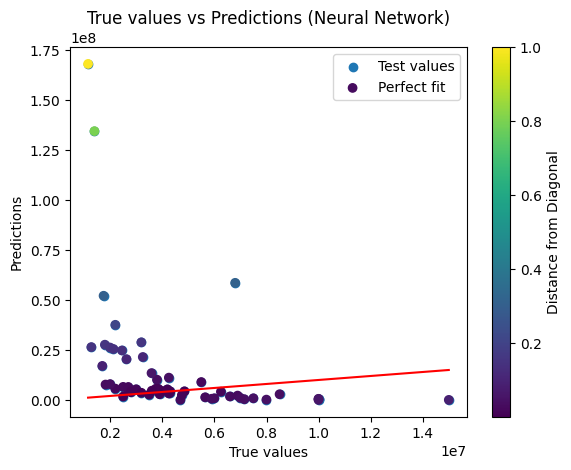

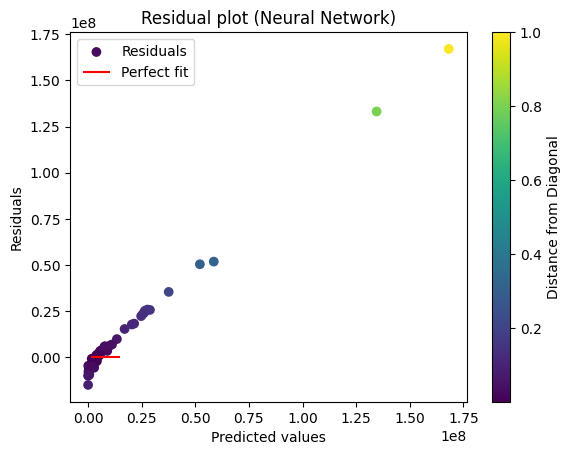

In [43]:
neural_network(X_train, y_train, X_test, y_test)

# Binary Regression

In [41]:
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(preprocessed_data.drop(['price', 'above_mean'], axis = 1), preprocessed_data['above_mean'], test_size = 0.2, random_state = 0)
display(X_train_binary)
display(y_train_binary)

,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label
176,33,0,93,0.0,4,1926,1926,4
200,36,0,93,0.0,3,2023,2023,2
157,36,0,65,0.0,2,1926,1926,4
27,37,0,36,0.0,1,1936,1936,5
173,35,0,108,0.0,4,1933,1933,4
...,...,...,...,...,...,...,...,...
251,36,0,139,0.0,5,1935,2009,4
192,34,0,80,0.0,3,1896,1933,5
117,34,0,59,0.0,2,1934,1934,4
47,33,0,174,0.0,6,1901,1901,5


176    1
200    1
157    0
27     0
173    0
      ..
251    1
192    1
117    0
47     1
172    0
Name: above_mean, Length: 225, dtype: int64

## Random Forrest Binary Regression

In [797]:
# Do the same for the binary classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gradient_boosting = GradientBoostingClassifier()
random_forest = RandomForestClassifier()

def classification(model, x_train, y_train, x_test, y_test):
    print(model.__class__.__name__)
    model.fit(x_train, y_train)
    score = cross_val_score(model, x_train, y_train, cv=5)
    print("Cross Val Scores", score)
    print("Test score: ", model.score(x_test, y_test))
    print("Accuracy: ", accuracy_score(y_test, model.predict(x_test)))

    return None

classification(gradient_boosting, X_train_binary, y_train_binary, X_test_binary, y_test_binary)
classification(random_forest, X_train_binary, y_train_binary, X_test_binary, y_test_binary)

GradientBoostingClassifier
Cross Val Scores [0.84444444 0.82222222 0.82222222 0.91111111 0.84444444]
Test score:  0.9649122807017544
Accuracy:  0.9649122807017544
RandomForestClassifier
Cross Val Scores [0.84444444 0.82222222 0.77777778 0.88888889 0.77777778]
Test score:  0.9473684210526315
Accuracy:  0.9473684210526315
